# Imports

In [1]:
from utils import *
import matplotlib.gridspec as gridspec
SEED = 0

# Parámetros

In [2]:
# FPCA
N_BASIS = 15
N_COMPONENTS = 3

# WGAN
N_EPOCHS = 2000
N_CRITIC = 5
LAMBDA_GP = 0.5
BATCH_SIZE = 128
LATENT_DIM = 1
CONDITION_DIM = 1
INPUT_DIM = 1
G_HIDDEN_LAYERS = 4
G_HIDDEN_DIM = 16
G_LEAKY_RELU = 0.1
D_HIDDEN_LAYERS = 2
D_HIDDEN_DIM = 64
D_DROPOUT = 0.4
D_LEAKY_RELU = 0.1
LR_GEN = 0.0002
LR_DIS = 0.0002
B1 = 0.5
B2 = 0.999

# Datos

## Carga y Análisis

In [3]:
data = pd.read_excel( 'mltan_database_2022.xlsx' )

data.rename(columns = {'norad':'NORAD'}, inplace=True)

print(f'{(len(data))} observaciones')
print(f'Primera observación: {data.epoch.min()}')
print(f'Última observación: {data.epoch.max()}')

7137 observaciones
Primera observación: 1967-11-07 00:00:00
Última observación: 2022-05-16 00:00:00


In [4]:
# En primer lugar filtramos observaciones para las cuales no se tiene el dato de masa

print('No contamos con la masa para un {:.2f}% de las observaciones'.format( np.mean(data.launch_mass.isna())*100 ))
data = data[data.launch_mass.notna()].reset_index(drop=True)
print(f'{len(data)} observaciones')

No contamos con la masa para un 4.34% de las observaciones
6827 observaciones


In [5]:
# Acotamos la muestra a un subgrupo de satélites
# La principal distinción es por el tipo de órbita, siendo las principales LEO (órbita baja) y GEO (órbita geoestacionaria - muy alta)
# LEO es la fracción más grande

data.groupby('orbit_class')['cospar_norad'].count() / data.shape[0]

orbit_class
Elliptical    0.013476
GEO           0.122016
LEO           0.834481
MEO           0.030028
Name: cospar_norad, dtype: float64

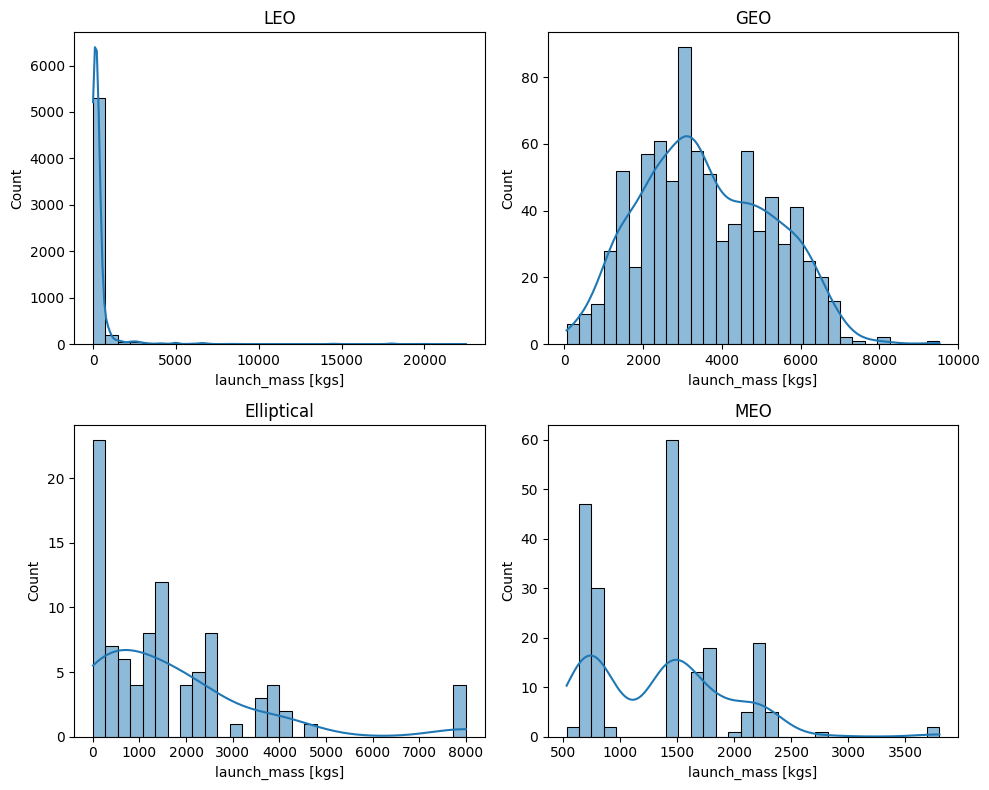

In [6]:
# Distintas masas se observan en los 4 tipos de órbitas. En general, en LEO se encuentran satélites por debajo de 1.000 kgs
# GEO presenta una distribución totalmente distinta con muchos satélites pesando varias toneladas
# Al ser la categoría con más observaciones, decidimos quedarnos sólo con los satélites de LEO

plt.figure(dpi=100, figsize=(10,8))
classes = pd.unique(data.orbit_class)

for i, orbit_class in zip( range(len(classes)), classes ):

  plt.subplot(2,2,i+1)
  sns.histplot(data[data.orbit_class == orbit_class].launch_mass, kde=True, bins=30)
  plt.xlabel('launch_mass [kgs]')
  plt.title(orbit_class)

plt.tight_layout()
plt.show()

In [7]:
data = data[data.orbit_class == 'LEO'].reset_index(drop=True)

In [8]:
# Un único dato estaba clasificado como Earth Observation bajo la columna Users (mal clasificado)
# Se trata del BRIK-II, lanzado por la fuerza aérea de los Países Bajos. Editamos este dato:

data.loc[data.users == 'Earth Observation', 'users'] = 'Military'

In [9]:
# Análisis según tipo de usuario

data.groupby('users')['cospar_norad'].count()

users
Civil          335
Commercial    4324
Government     729
Military       309
Name: cospar_norad, dtype: int64

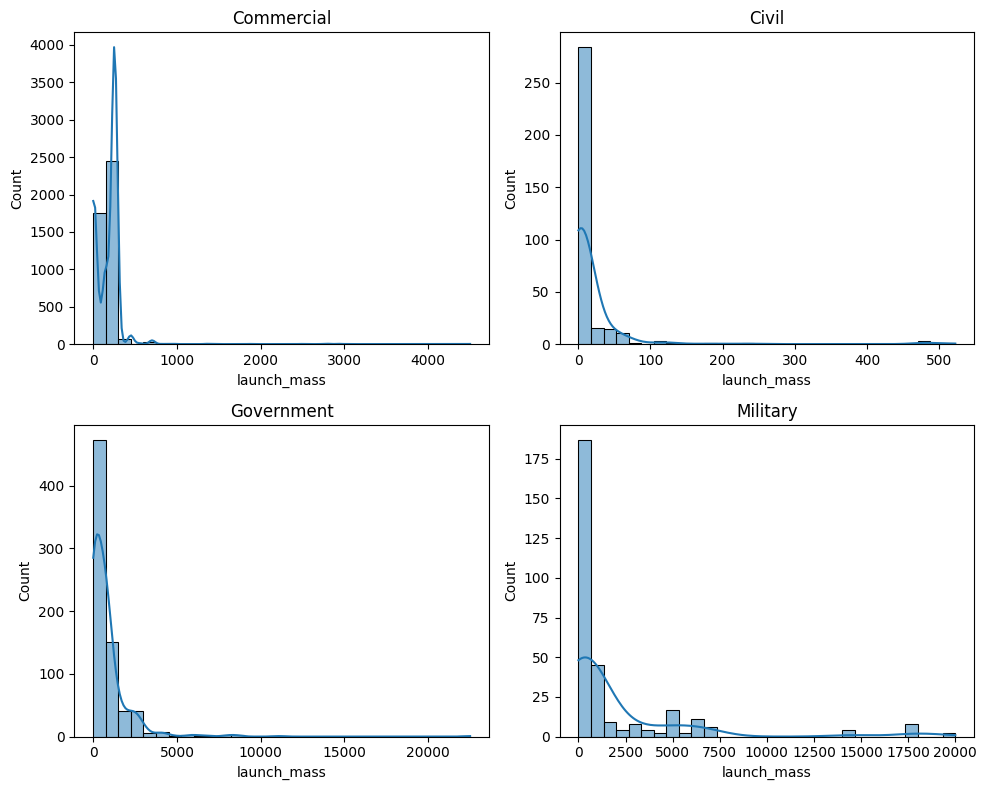

In [10]:
plt.figure(dpi=100, figsize=(10,8))
users = pd.unique(data.users)

for i, user in zip( range(len(users)), users ):

  plt.subplot(2,2,i+1)
  sns.histplot( data[data.users == user].launch_mass, bins=30, kde=True )
  plt.title(user)

plt.tight_layout()
plt.show()

In [11]:
# Si bien LEO se caracteriza por satélites pequeños, vemos algunos datos pesando varias toneladas
# Viéndolos en detalle vemos que por encima de los 4.000 kgs, todos los satélites pertenecen a usuarios
# militares o gubernamentales

# optamos por descartar todas las observaciones por encima de los 4.000 kilos

print('Un {:.3f}% de los satélites en LEO superan los 4.000 kilos'.format(np.mean(data.launch_mass >= 4000)))
data.sort_values(by='launch_mass', ascending=False).head(5)

Un 0.013% de los satélites en LEO superan los 4.000 kilos


,cospar,NORAD,cospar_norad,orbit_class,orbit_type,launch_mass,dry_mass,users,date,GEO_long_degrees,perigee,apogee,inclination,operator,country,year,arg_of_perigee,epoch,RAAN,mltan
4338,2021-035A,48275,2021-035A-48275,LEO,Non-Polar Inclined,22500.0,NaN,Government,2021-04-29,0.0,170.0,381,41.47,China Manned Space Engineering Office (CMSEO),China,2021,169.623,2021-04-29,222.2892,0.341232
1148,2022-009A,51445,2022-009A-51445,LEO,Sun-Synchronous,20000.0,15500.0,Military,2022-02-02,0.0,491.0,524,97.89,National Reconnaissance Office (NRO),USA,2022,NaN,NaT,NaN,NaN
881,2021-032A,48247,2021-032A-48247,LEO,Sun-Synchronous,20000.0,NaN,Military,2021-04-26,0.0,524.0,758,98.20,National Reconnaissance Office (NRO),USA,2021,NaN,NaT,NaN,NaN
878,2011-002A,37348,2011-002A-37348,LEO,Elliptical,18000.0,10000.0,Military,2011-01-20,0.0,200.0,1000,97.80,National Reconnaissance Office (NRO),USA,2011,NaN,NaT,NaN,NaN
877,2005-042A,28888,2005-042A-28888,LEO,Elliptical,18000.0,10000.0,Military,2005-10-19,0.0,264.0,1050,97.90,National Reconnaissance Office (NRO),USA,2005,NaN,NaT,NaN,NaN


In [12]:
data = data[data.launch_mass < 4000].reset_index(drop=True)

## Agrupación por año

Habiéndonos quedado con los satélites lanzados a LEO por debajo de los 4.000 kilos, pasamos a agrupar por año

In [13]:
data = data[['launch_mass', 'year']].sort_values(by='year').reset_index(drop=True) # Me quedo con masa y año de lanzamiento
print(data.groupby('year').launch_mass.count())

# Como buscamos ahora ajustar una distribución para cada año, descartamos los años con pocas observaciones
# Arbitrariamente descartamos los años con menos de 10 lanzamientos
# Notar que la caída entre 2021 y 2022 se debe a que todavía no terminó el año al momento de hacer este análisis

data = data[data.year >= 1998].reset_index(drop=True)

year
1974       1
1984       2
1990       1
1991       3
1993       6
1994       2
1995       8
1996       6
1997      57
1998      75
1999      64
2000      15
2001      21
2002      25
2003      32
2004      26
2005      18
2006      24
2007      50
2008      38
2009      55
2010      31
2011      45
2012      40
2013      98
2014      91
2015     134
2016     121
2017     351
2018     317
2019     339
2020    1154
2021    1687
2022     687
Name: launch_mass, dtype: int64


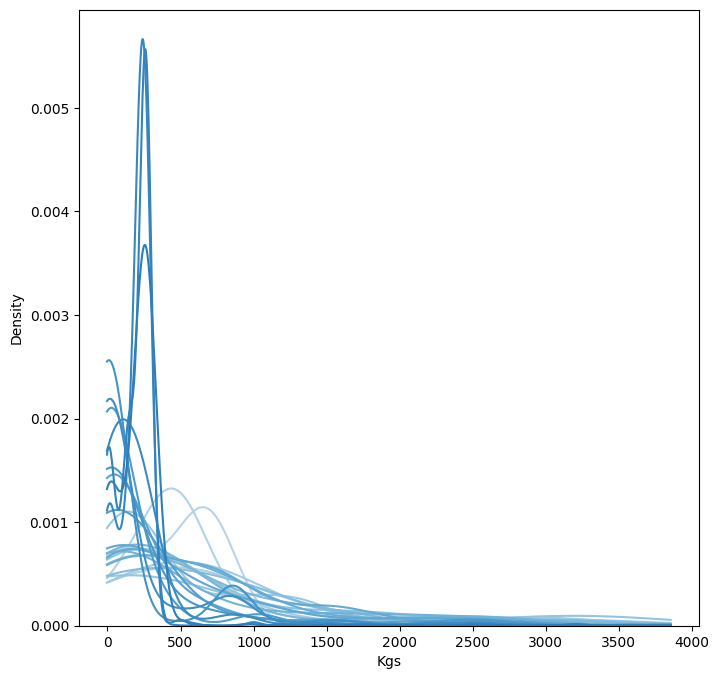

In [14]:
# Se observa una gran conentración de las masas en torno a los 200 kgs para los últimos años
# A juzgar por los picos de las densidades, para los primeros años esta concentración no era tan alta, siendo más comunes satélites más pesados
# Vale aclarar que la gran concentración de los últimos años se debe a la constelación Starlink de SpaceX
# En una muestra de 5600 observaciones, casi la mitad pertenece a esta constelación formada por satélites idénticos de entre 230 y 260 kilos, lanzados entre 2019 y 2022

data_plot = data.copy()

kdes = get_kdes(data_plot, 'launch_mass', 'year', data_plot.year.unique())

# Evalúo las log-densidades sobre una grilla
grid_points = list(np.linspace(min(data_plot.launch_mass)-4, max(data_plot.launch_mass)+4, 1000))
data_matrix = [[kdes[t].score( np.array([[point]]) ) for point in grid_points] for t in data_plot.year.unique()]

plt.figure(dpi=100, figsize=(8,8))
for i, d in zip(np.linspace(0.3,0.7, len(data_matrix)), data_matrix):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('Kgs')
plt.show()

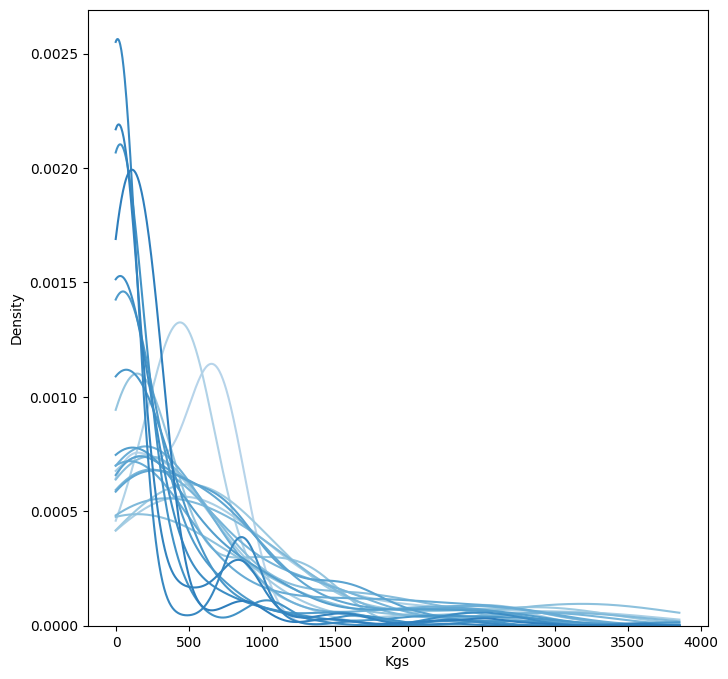

In [15]:
# Hasta 2019

plt.figure(dpi=100, figsize=(8,8))
for i, d in zip(np.linspace(0.3,0.7, len(data_matrix[:-3])), data_matrix[:-3]):
  plt.plot(grid_points, np.exp(d), color=BLUE(i))

plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('Kgs')
plt.show()

# Proyecciones

Ahora aplicamos los 3 métodos que desarrollamos para predecir la evolución de las densidades

Ajustaremos los 3 modelos hasta el 2021, y compararemos las predicciones para 2022 con la distribución observada para dicho año a la fecha

In [16]:
data = data.rename(columns={'year':'time'})
VARS = ['launch_mass']
X_train = data[data.time < 2022].reset_index(drop=True)
X_test = data[data.time == 2022].reset_index(drop=True)
H_STEPS = 1
TIME_PERIODS = pd.unique(X_train.time)
FORECAST_PERIODS = np.arange(TIME_PERIODS[-1]+1, TIME_PERIODS[-1]+1+H_STEPS)

kdes = get_kdes(data, 'launch_mass', 'time', pd.unique(data.time))
    
# Evalúo las log-densidades sobre una grilla
grid_points = np.linspace(min(data.launch_mass)-4, max(data.launch_mass)+4, 1000)
data_matrix = [kdes[t].score_samples(grid_points.reshape(-1,1)) for t in TIME_PERIODS]

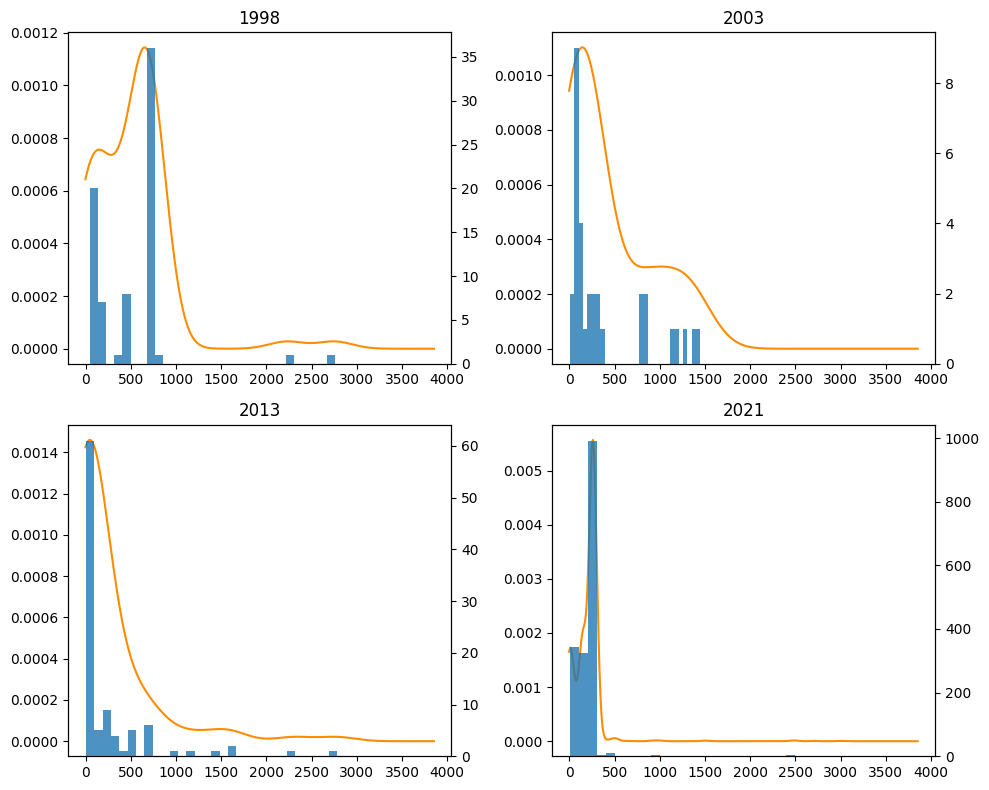

In [17]:
plt.figure(dpi=100, figsize=(10,8))

ax1 = plt.subplot(2,2,1)
ax2 = ax1.twinx()
ax1.plot(grid_points, np.exp(data_matrix[0]), 'darkorange')
ax2.hist(data[data.time==TIME_PERIODS[0]].launch_mass, bins=30, alpha=0.8)
plt.xlabel('launch_mass [kgs]')
plt.title(TIME_PERIODS[0])

ax1 = plt.subplot(2,2,2)
ax2 = ax1.twinx()
ax1.plot(grid_points, np.exp(data_matrix[5]), 'darkorange')
ax2.hist(data[data.time==TIME_PERIODS[5]].launch_mass, bins=30, alpha=0.8)
plt.xlabel('launch_mass [kgs]')
plt.title(TIME_PERIODS[5])

ax1 = plt.subplot(2,2,3)
ax2 = ax1.twinx()
ax1.plot(grid_points, np.exp(data_matrix[15]), 'darkorange')
ax2.hist(data[data.time==TIME_PERIODS[15]].launch_mass, bins=30, alpha=0.8)
plt.xlabel('launch_mass [kgs]')
plt.title(TIME_PERIODS[15])

ax1 = plt.subplot(2,2,4)
ax2 = ax1.twinx()
ax1.plot(grid_points, np.exp(data_matrix[-1]), 'darkorange')
ax2.hist(data[data.time==TIME_PERIODS[-1]].launch_mass, bins=30, alpha=0.8)
plt.xlabel('launch_mass [kgs]')
plt.title(TIME_PERIODS[-1])

plt.tight_layout()

plt.show()

## Paramétrico

Ajustamos mixturas de dos log normales

In [18]:
np.random.seed(SEED)
mixtures = Mixtures(X_train, vars=VARS, n_components=2, distributions=LogNormalDistribution)
mixtures.fit()
mixtures.forecast(steps=H_STEPS, predict=['mean','weight'])

/home/lipinoelbreve/venvs/tesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/lipinoelbreve/venvs/tesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/lipinoelbreve/venvs/tesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/lipinoelbreve/venvs/tesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without 

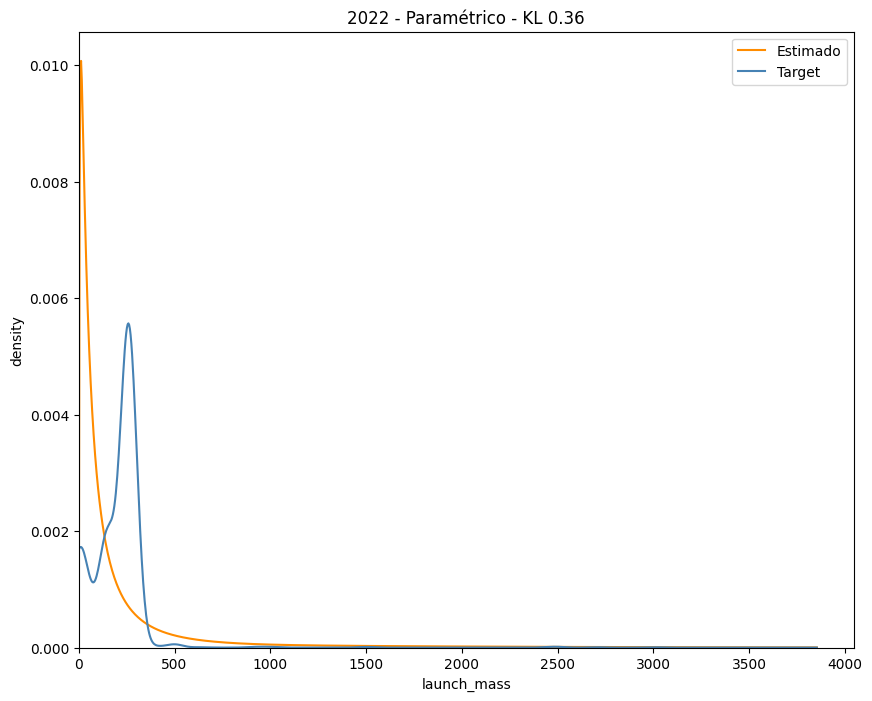

In [19]:
# COMENTARIO: Usar get_kl

output_parametrico = np.exp(mixtures.new_mixtures[0].log_probability(grid_points))
KL_parametrico = get_kl( output_parametrico[1:-1], np.exp(data_matrix[-1])[1:-1] )

plt.figure(dpi=100, figsize=(10,8))

plt.plot(grid_points, output_parametrico, 'darkorange', label='Estimado')
plt.plot(grid_points, np.exp(data_matrix[-1]), 'steelblue', label='Target')
plt.legend()
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=0)
plt.title('2022 - Paramétrico - KL {:.2f}'.format(KL_parametrico))


plt.xlabel('launch_mass')
plt.ylabel('density')

plt.show()

In [20]:
# Estimo los parámetros para el grupo de test

mix_test = Mixtures(X_test, vars=VARS, n_components=2, distributions=LogNormalDistribution)
mix_test.fit()

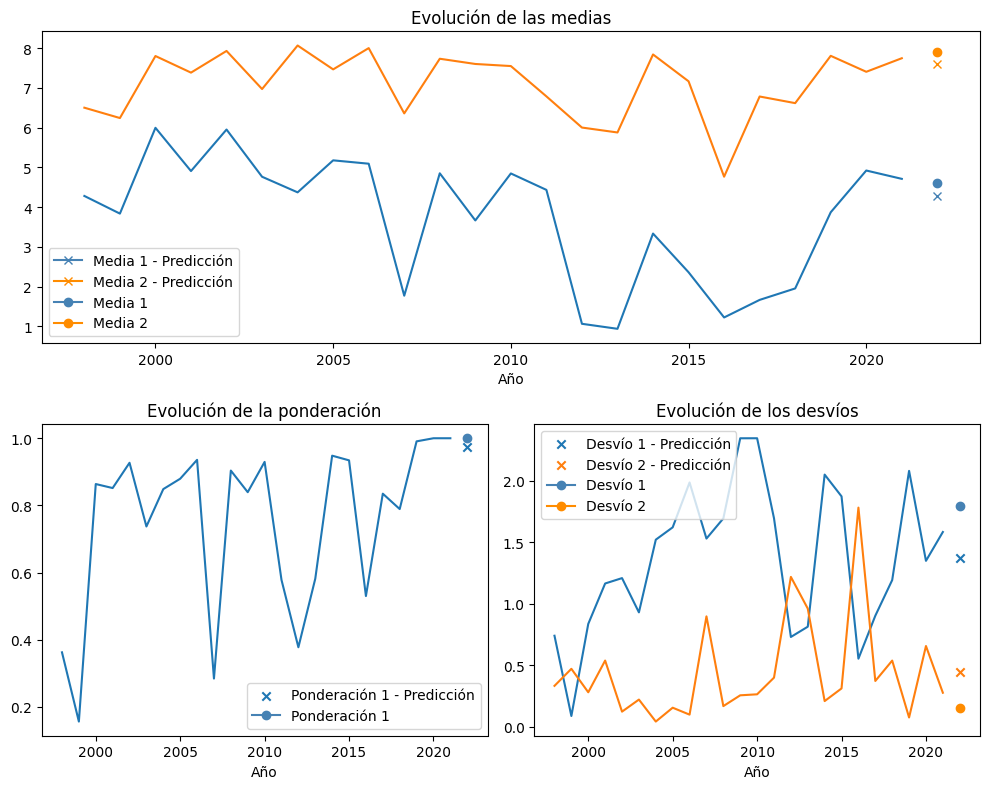

In [21]:
gs = gridspec.GridSpec(2, 2)

plt.figure(dpi=100, figsize=(10,8))

ax = plt.subplot(gs[0, :]) # row 0, col 0

plt.xlabel('Año')
plt.title('Evolución de las medias')
plt.plot(mixtures.medias)
plt.plot(mixtures.pred_mean.m_0, 'steelblue', marker='x', label='Media 1 - Predicción')
plt.plot(mixtures.pred_mean.m_1, 'darkorange', marker='x', label='Media 2 - Predicción')

plt.plot(mix_test.medias.m_0, 'steelblue', marker='o', label='Media 1')
plt.plot(mix_test.medias.m_1, 'darkorange', marker='o', label='Media 2')
plt.tight_layout()
plt.legend()


ax = plt.subplot(gs[1, 0]) # row 0, col 1


plt.xlabel('Año')
plt.title('Evolución de la ponderación')
plt.plot(mixtures.weights.w_0)

plt.scatter(FORECAST_PERIODS, mixtures.pred_weight.w_0, marker='x', label='Ponderación 1 - Predicción')
plt.plot(mix_test.weights.w_0, 'steelblue', marker='o', label='Ponderación 1')
plt.tight_layout()
plt.legend()


ax = plt.subplot(gs[1, 1]) # row 1, span all column

plt.xlabel('Año')
plt.title('Evolución de los desvíos')
plt.plot(mixtures.desvios)
plt.scatter(FORECAST_PERIODS, mixtures.pred_sd[0], marker='x', label='Desvío 1 - Predicción')
plt.scatter(FORECAST_PERIODS, mixtures.pred_sd[1], marker='x', label='Desvío 2 - Predicción')
plt.plot(mix_test.desvios.d_0, 'steelblue', marker='o', label='Desvío 1')
plt.plot(mix_test.desvios.d_1, 'darkorange', marker='o', label='Desvío 2')
plt.tight_layout()
plt.legend()

plt.show()


## FPCA

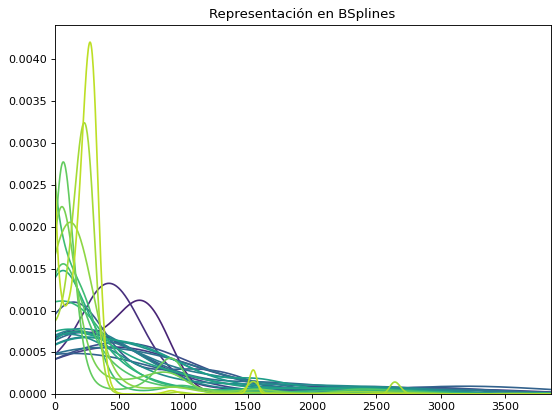

In [22]:
fpca_sats = Fpca(data_matrix, grid_points, n_basis=N_BASIS)

plt.figure(figsize=(8, 6), dpi=80)

for n, i in zip(np.linspace(0.1,0.9,len(TIME_PERIODS)), range(len(TIME_PERIODS))):
  plt.plot(grid_points, np.exp(fpca_sats.fd[i](grid_points).reshape(-1)), color=VIRIDIS(n))

plt.title('Representación en BSplines')
plt.xlim((grid_points[0], grid_points[-1]))
plt.gca().set_ylim(bottom=0)
plt.show()

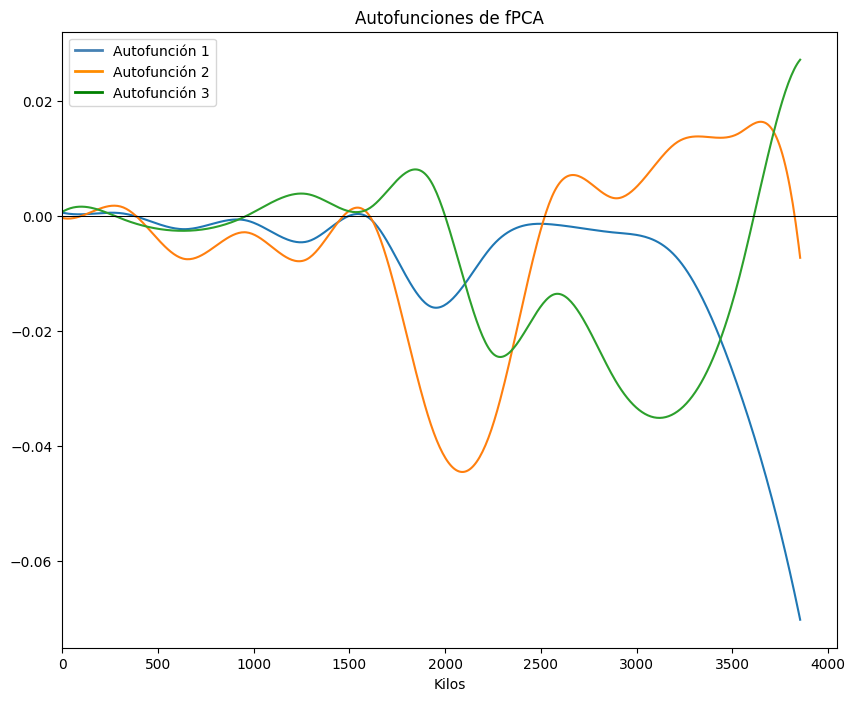

In [23]:

custom_lines = [Line2D([0], [0], color='steelblue', lw=2),
                Line2D([0], [0], color='darkorange', lw=2),
                Line2D([0], [0], color='green', lw=2)]


fpca_sats.fit_fpca(N_COMPONENTS)

ax = plt.figure(dpi=100, figsize=(10,8))
fpca_sats.fpca.components_.plot(ax)
plt.title('Autofunciones de fPCA')
plt.axhline(0, color='black', linewidth=0.75)
plt.gca().set_xlim(left=0)
plt.legend(custom_lines, ['Autofunción 1', 'Autofunción 2', 'Autofunción 3'])

plt.xlabel('Kilos')

plt.show()



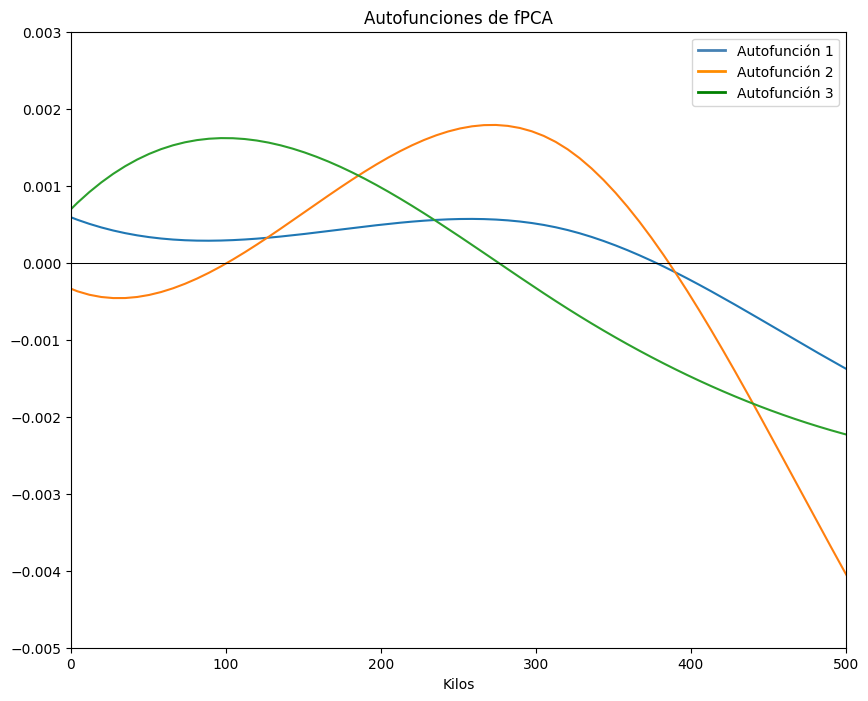

In [24]:

custom_lines = [Line2D([0], [0], color='steelblue', lw=2),
                Line2D([0], [0], color='darkorange', lw=2),
                Line2D([0], [0], color='green', lw=2)]


fpca_sats.fit_fpca(N_COMPONENTS)

ax = plt.figure(dpi=100, figsize=(10,8))
fpca_sats.fpca.components_.plot(ax)
plt.title('Autofunciones de fPCA')
plt.axhline(0, color='black', linewidth=0.75)
plt.gca().set_xlim(left=0)
plt.legend(custom_lines, ['Autofunción 1', 'Autofunción 2', 'Autofunción 3'])
plt.xlim((0,500))
plt.ylim((-0.005,0.003))
plt.xlabel('Kilos')

plt.show()



In [25]:
print(fpca_sats.fpca.explained_variance_ratio_)
print(fpca_sats.fpca.explained_variance_ratio_.sum())

[0.87962514 0.07375476 0.041008  ]
0.9943878957936372


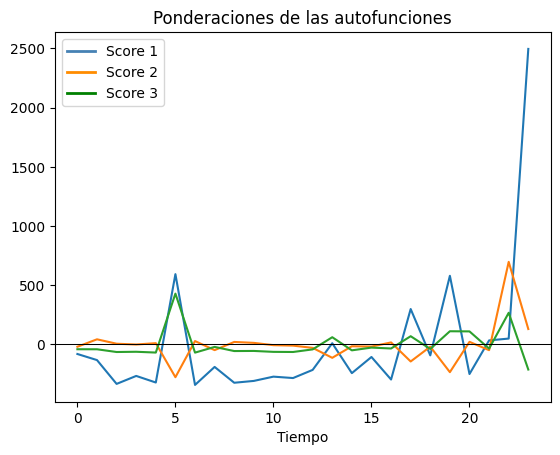

In [26]:

plt.plot(fpca_sats.scores)

custom_lines = [Line2D([0], [0], color='steelblue', lw=2),
                Line2D([0], [0], color='darkorange', lw=2),
                Line2D([0], [0], color='green', lw=2)]

plt.title('Ponderaciones de las autofunciones')
plt.xlabel('Tiempo')
plt.axhline(0, color='black', linewidth=0.75)
plt.legend(custom_lines, ['Score 1', 'Score 2', 'Score 3'])
plt.show()

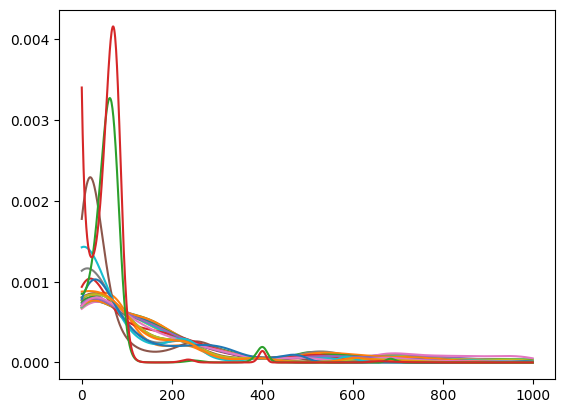

In [27]:
for i in range(len(TIME_PERIODS)):
  plt.plot(np.exp(fpca_sats.results[i]))
plt.show()

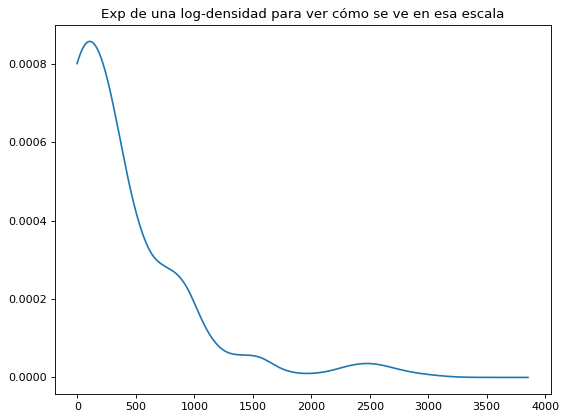

In [28]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(grid_points, np.exp(fpca_sats.results[15]))
plt.title('Exp de una log-densidad para ver cómo se ve en esa escala')
#plt.xlim((0,1))
plt.show()

In [29]:
fpca_sats.fit_time_series(h_steps=H_STEPS)

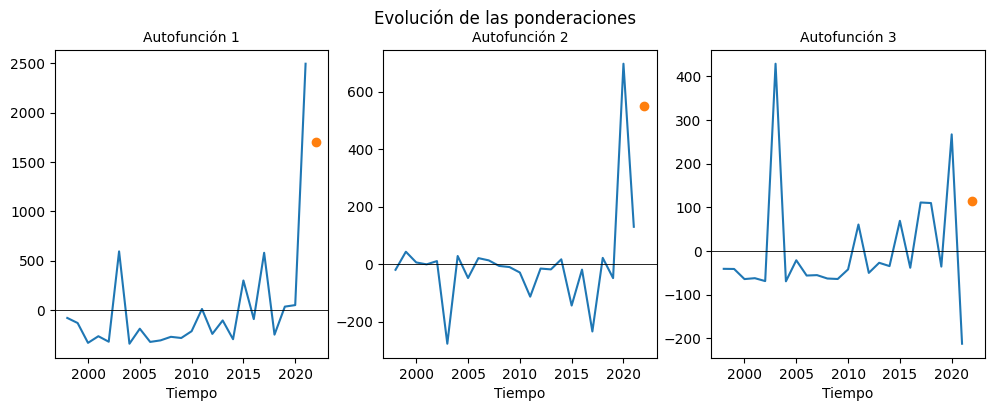

In [30]:
plt.figure(dpi=100, figsize=(12,4))

for i in range(N_COMPONENTS):
  plt.subplot(1,3,i+1)
  plt.plot(TIME_PERIODS, fpca_sats.scores[:,i])
  pred_plot = pd.DataFrame(fpca_sats.pred_w[:,i], index=FORECAST_PERIODS)
  plt.plot(pred_plot, marker='o')
  plt.axhline(0, color='black', linewidth=0.6)
  plt.title('Autofunción {}'.format(i+1), fontsize=10)
  plt.xlabel('Tiempo')

plt.suptitle('Evolución de las ponderaciones')
plt.show()

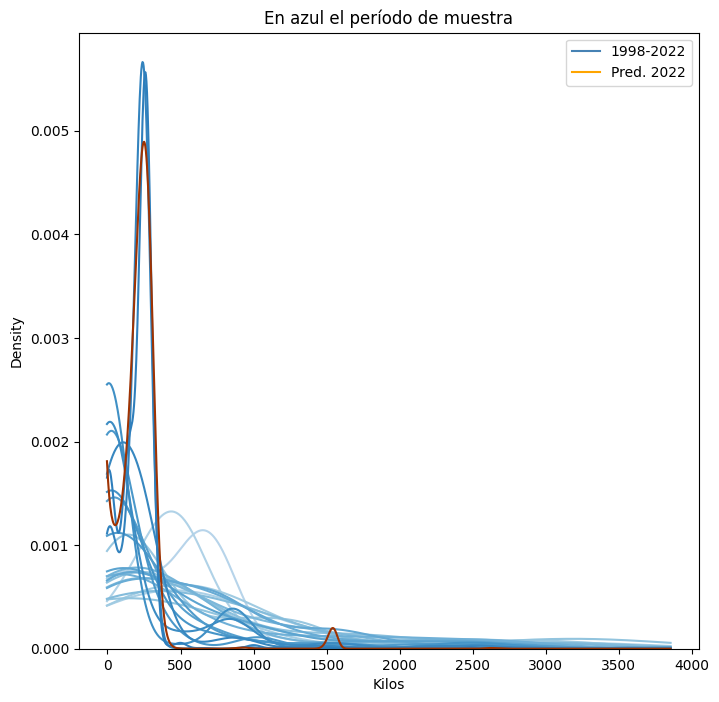

In [31]:
fpca_sats.predict(exp=True, normalize=True)

plt.figure(dpi=100, figsize=(8,8))

for n, i in zip( np.linspace(0.3 ,0.7 , len(TIME_PERIODS)), data_matrix):
  plt.plot(grid_points, np.exp(i), color=BLUE(n))

for i in fpca_sats.pred_f:
  plt.plot(grid_points, i, color=ORANGE(0.9))

kls_f = [get_kl( fpca_sats.pred_f[i][1:-1], np.exp(data_matrix[-1])[1:-1] ) for i in range(H_STEPS)]
kl_f = np.mean(kls_f)
plt.xlabel('Tiempo')
plt.title('En azul el período de muestra')
plt.plot([], [], color='steelblue', label='1998-2022')
plt.plot([], [], color='orange', label='Pred. 2022')
plt.gca().set_ylim(bottom=0)
plt.ylabel('Density')
plt.xlabel('Kilos')
plt.legend()
plt.show()

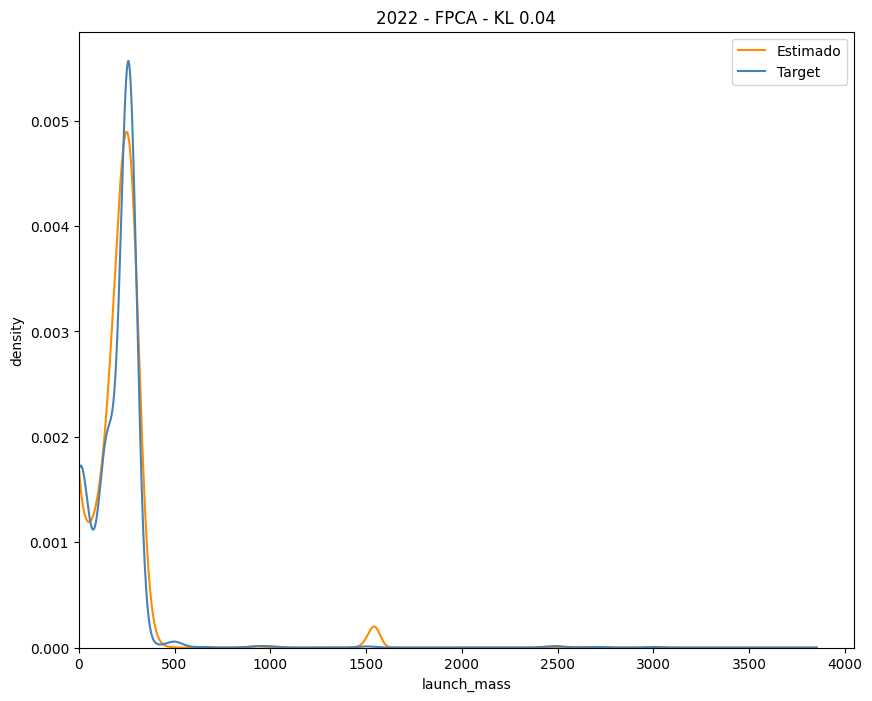

In [32]:
KL_fpca = get_kl( fpca_sats.pred_f[0][1:-1], np.exp(data_matrix[-1])[1:-1] )

plt.figure(dpi=100, figsize=(10,8))

plt.plot(grid_points, fpca_sats.pred_f[0], 'darkorange', label='Estimado')
plt.plot(grid_points, np.exp(data_matrix[-1]), 'steelblue', label='Target')
plt.legend()
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=0)
plt.title('2022 - FPCA - KL {:.2f}'.format(KL_fpca))

plt.xlabel('launch_mass')
plt.ylabel('density')

plt.show()

## WGAN

In [33]:
X_train

,launch_mass,time
0,45.0,1998
1,45.0,1998
2,45.0,1998
3,689.0,1998
4,689.0,1998
...,...,...
4846,260.0,2021
4847,260.0,2021
4848,260.0,2021
4849,260.0,2021


In [34]:
np.random.seed(SEED)
torch.manual_seed(SEED)

wgan_sats = Wgan(data = X_train,
               vars = VARS,
               latent_dim = LATENT_DIM,
               condition_dim = CONDITION_DIM,
               g_hidden_layers = G_HIDDEN_LAYERS,
               g_hidden_dim = G_HIDDEN_DIM,
               g_leaky_relu = G_LEAKY_RELU,
               d_hidden_layers = D_HIDDEN_LAYERS,
               d_hidden_dim = D_HIDDEN_DIM,
               d_dropout = D_DROPOUT,
               d_leaky_relu = D_LEAKY_RELU,
               input_dim = INPUT_DIM,
               lr_gen = LR_GEN,
               lr_dis = LR_DIS,
               b1 = B1,
               b2 = B2,
               lambda_gp = LAMBDA_GP,
               n_critic = N_CRITIC,
               batch_size = BATCH_SIZE,
               device = DEVICE)

[0/2000]: loss_d: 0.466, loss_g: -0.471


2020.0


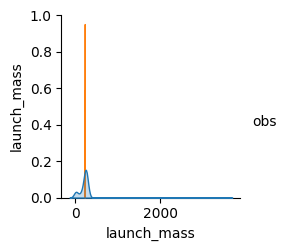

[10/2000]: loss_d: 0.067, loss_g: -0.343
[20/2000]: loss_d: 0.209, loss_g: -0.417
[30/2000]: loss_d: 0.489, loss_g: -0.588
[40/2000]: loss_d: 0.515, loss_g: -0.600
[50/2000]: loss_d: 0.516, loss_g: -0.560


2021.0


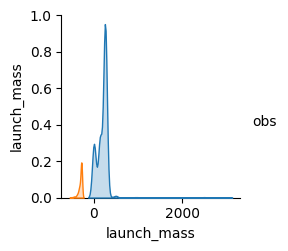

[60/2000]: loss_d: -0.320, loss_g: -0.158
[70/2000]: loss_d: -0.117, loss_g: -0.210
[80/2000]: loss_d: 0.062, loss_g: -0.313
[90/2000]: loss_d: 0.533, loss_g: -0.367
[100/2000]: loss_d: -0.368, loss_g: -0.199


2020.0


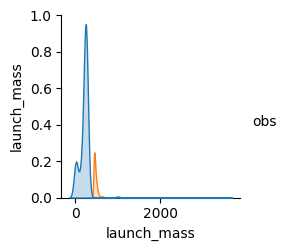

[110/2000]: loss_d: -0.020, loss_g: -0.236
[120/2000]: loss_d: 0.174, loss_g: -0.317
[130/2000]: loss_d: 0.436, loss_g: -0.399
[140/2000]: loss_d: 0.519, loss_g: -0.234
[150/2000]: loss_d: -0.012, loss_g: -0.179


2021.0


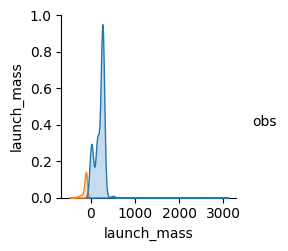

[160/2000]: loss_d: -0.176, loss_g: -0.229
[170/2000]: loss_d: 0.041, loss_g: -0.334
[180/2000]: loss_d: 0.399, loss_g: -0.481
[190/2000]: loss_d: 0.042, loss_g: -0.324
[200/2000]: loss_d: 0.124, loss_g: -0.417


2019.0


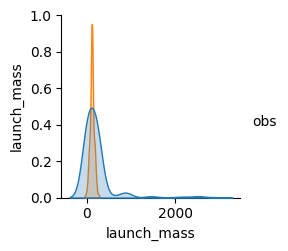

[210/2000]: loss_d: -0.049, loss_g: -0.405
[220/2000]: loss_d: 0.157, loss_g: -0.554
[230/2000]: loss_d: 0.140, loss_g: -0.392
[240/2000]: loss_d: 0.117, loss_g: -0.467
[250/2000]: loss_d: 0.103, loss_g: -0.488


2020.0


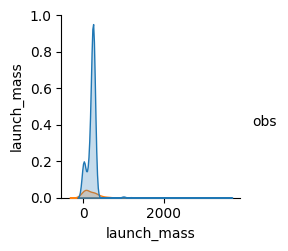

[260/2000]: loss_d: 0.087, loss_g: -0.481
[270/2000]: loss_d: 0.086, loss_g: -0.467
[280/2000]: loss_d: 0.088, loss_g: -0.445
[290/2000]: loss_d: 0.099, loss_g: -0.449
[300/2000]: loss_d: 0.106, loss_g: -0.479


2014.0


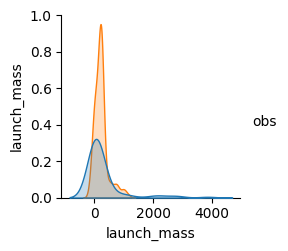

[310/2000]: loss_d: 0.115, loss_g: -0.521
[320/2000]: loss_d: 0.121, loss_g: -0.503
[330/2000]: loss_d: 0.119, loss_g: -0.505
[340/2000]: loss_d: 0.121, loss_g: -0.507
[350/2000]: loss_d: 0.120, loss_g: -0.521


2019.0


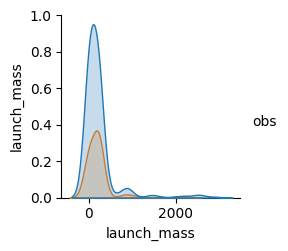

[360/2000]: loss_d: 0.131, loss_g: -0.528
[370/2000]: loss_d: 0.129, loss_g: -0.521
[380/2000]: loss_d: 0.135, loss_g: -0.517
[390/2000]: loss_d: 0.143, loss_g: -0.520
[400/2000]: loss_d: 0.135, loss_g: -0.520


2020.0


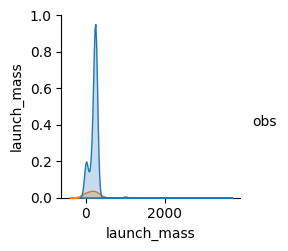

[410/2000]: loss_d: 0.156, loss_g: -0.526
[420/2000]: loss_d: 0.150, loss_g: -0.527
[430/2000]: loss_d: 0.155, loss_g: -0.510
[440/2000]: loss_d: 0.163, loss_g: -0.503
[450/2000]: loss_d: 0.161, loss_g: -0.536


2021.0


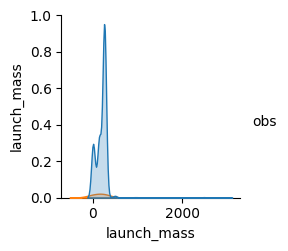

[460/2000]: loss_d: 0.155, loss_g: -0.458
[470/2000]: loss_d: 0.169, loss_g: -0.490
[480/2000]: loss_d: 0.173, loss_g: -0.509
[490/2000]: loss_d: 0.153, loss_g: -0.497
[500/2000]: loss_d: 0.162, loss_g: -0.462


2020.0


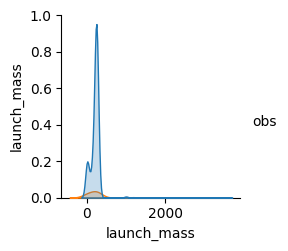

[510/2000]: loss_d: 0.154, loss_g: -0.475
[520/2000]: loss_d: 0.143, loss_g: -0.470
[530/2000]: loss_d: 0.123, loss_g: -0.466
[540/2000]: loss_d: 0.120, loss_g: -0.463
[550/2000]: loss_d: 0.119, loss_g: -0.437


2017.0


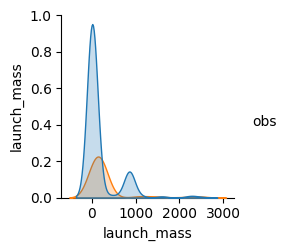

[560/2000]: loss_d: 0.111, loss_g: -0.460
[570/2000]: loss_d: 0.116, loss_g: -0.451
[580/2000]: loss_d: 0.114, loss_g: -0.434
[590/2000]: loss_d: 0.107, loss_g: -0.429
[600/2000]: loss_d: 0.108, loss_g: -0.461


2020.0


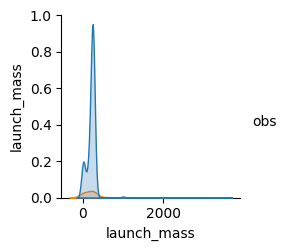

[610/2000]: loss_d: 0.114, loss_g: -0.428
[620/2000]: loss_d: 0.112, loss_g: -0.451
[630/2000]: loss_d: 0.103, loss_g: -0.452
[640/2000]: loss_d: 0.112, loss_g: -0.457
[650/2000]: loss_d: 0.098, loss_g: -0.459


2021.0


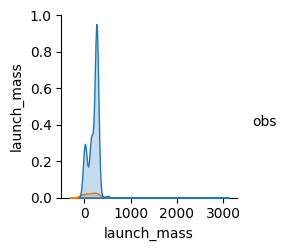

[660/2000]: loss_d: 0.102, loss_g: -0.442
[670/2000]: loss_d: 0.109, loss_g: -0.460
[680/2000]: loss_d: 0.103, loss_g: -0.455
[690/2000]: loss_d: 0.109, loss_g: -0.466
[700/2000]: loss_d: 0.108, loss_g: -0.462


2018.0


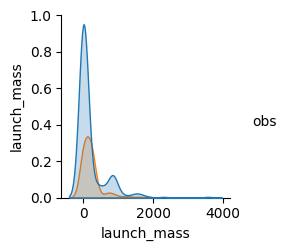

[710/2000]: loss_d: 0.114, loss_g: -0.479
[720/2000]: loss_d: 0.108, loss_g: -0.460
[730/2000]: loss_d: 0.103, loss_g: -0.471
[740/2000]: loss_d: 0.101, loss_g: -0.474
[750/2000]: loss_d: 0.098, loss_g: -0.459


2021.0


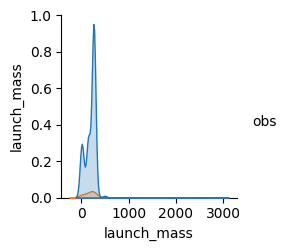

[760/2000]: loss_d: 0.092, loss_g: -0.468
[770/2000]: loss_d: 0.101, loss_g: -0.474
[780/2000]: loss_d: 0.097, loss_g: -0.474
[790/2000]: loss_d: 0.105, loss_g: -0.475
[800/2000]: loss_d: 0.089, loss_g: -0.464


2020.0


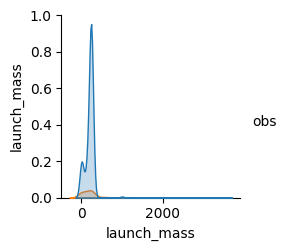

[810/2000]: loss_d: 0.107, loss_g: -0.477
[820/2000]: loss_d: 0.097, loss_g: -0.471
[830/2000]: loss_d: 0.097, loss_g: -0.463
[840/2000]: loss_d: 0.102, loss_g: -0.486
[850/2000]: loss_d: 0.098, loss_g: -0.474


2018.0


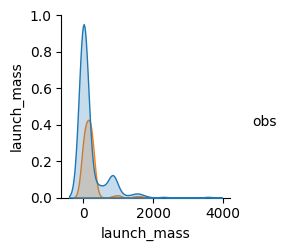

[860/2000]: loss_d: 0.105, loss_g: -0.470
[870/2000]: loss_d: 0.095, loss_g: -0.490
[880/2000]: loss_d: 0.113, loss_g: -0.480
[890/2000]: loss_d: 0.102, loss_g: -0.486
[900/2000]: loss_d: 0.104, loss_g: -0.475


2021.0


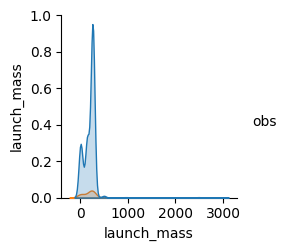

[910/2000]: loss_d: 0.097, loss_g: -0.501
[920/2000]: loss_d: 0.096, loss_g: -0.487
[930/2000]: loss_d: 0.106, loss_g: -0.505
[940/2000]: loss_d: 0.122, loss_g: -0.506
[950/2000]: loss_d: 0.136, loss_g: -0.519


2020.0


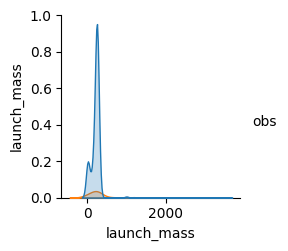

[960/2000]: loss_d: 0.131, loss_g: -0.506
[970/2000]: loss_d: 0.133, loss_g: -0.524
[980/2000]: loss_d: 0.131, loss_g: -0.544
[990/2000]: loss_d: 0.147, loss_g: -0.531
[1000/2000]: loss_d: 0.151, loss_g: -0.532


2007.0


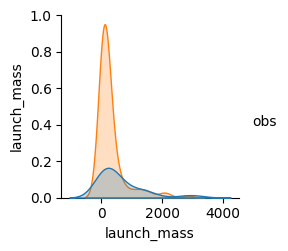

[1010/2000]: loss_d: 0.148, loss_g: -0.524
[1020/2000]: loss_d: 0.154, loss_g: -0.534
[1030/2000]: loss_d: 0.150, loss_g: -0.538
[1040/2000]: loss_d: 0.139, loss_g: -0.539
[1050/2000]: loss_d: 0.138, loss_g: -0.544


2017.0


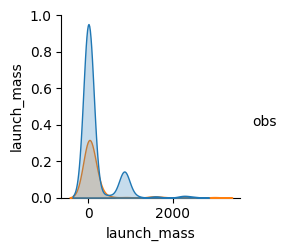

[1060/2000]: loss_d: 0.455, loss_g: -0.946
[1070/2000]: loss_d: 0.349, loss_g: -0.888
[1080/2000]: loss_d: -0.104, loss_g: -0.274
[1090/2000]: loss_d: 0.074, loss_g: -0.447
[1100/2000]: loss_d: 0.163, loss_g: -0.538


2004.0


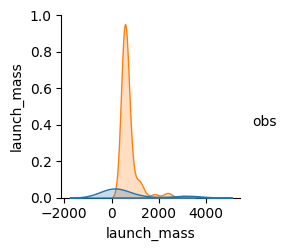

[1110/2000]: loss_d: 0.091, loss_g: -0.452
[1120/2000]: loss_d: -0.066, loss_g: -0.368
[1130/2000]: loss_d: -0.025, loss_g: -0.425
[1140/2000]: loss_d: 0.211, loss_g: -0.495
[1150/2000]: loss_d: 0.183, loss_g: -0.472


2019.0


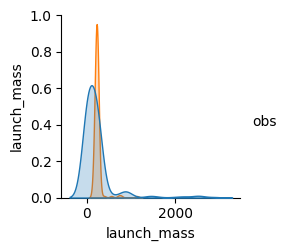

[1160/2000]: loss_d: 0.060, loss_g: -0.369
[1170/2000]: loss_d: 0.042, loss_g: -0.375
[1180/2000]: loss_d: 0.156, loss_g: -0.554
[1190/2000]: loss_d: 0.163, loss_g: -0.585
[1200/2000]: loss_d: 0.048, loss_g: -0.473


2020.0


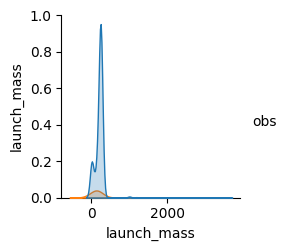

[1210/2000]: loss_d: 0.052, loss_g: -0.474
[1220/2000]: loss_d: 0.087, loss_g: -0.508
[1230/2000]: loss_d: 0.101, loss_g: -0.509
[1240/2000]: loss_d: 0.110, loss_g: -0.523
[1250/2000]: loss_d: 0.106, loss_g: -0.501


2020.0


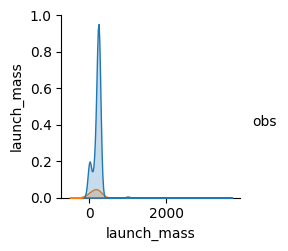

[1260/2000]: loss_d: 0.126, loss_g: -0.523
[1270/2000]: loss_d: 0.126, loss_g: -0.505
[1280/2000]: loss_d: 0.132, loss_g: -0.512
[1290/2000]: loss_d: 0.137, loss_g: -0.522
[1300/2000]: loss_d: 0.121, loss_g: -0.508


2021.0


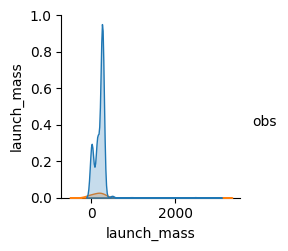

[1310/2000]: loss_d: 0.131, loss_g: -0.537
[1320/2000]: loss_d: 0.131, loss_g: -0.533
[1330/2000]: loss_d: 0.121, loss_g: -0.542
[1340/2000]: loss_d: 0.126, loss_g: -0.515
[1350/2000]: loss_d: 0.137, loss_g: -0.537


2021.0


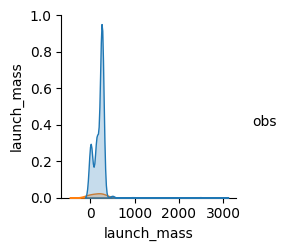

[1360/2000]: loss_d: 0.129, loss_g: -0.530
[1370/2000]: loss_d: 0.130, loss_g: -0.534
[1380/2000]: loss_d: 0.134, loss_g: -0.529
[1390/2000]: loss_d: 0.133, loss_g: -0.542
[1400/2000]: loss_d: 0.132, loss_g: -0.521


2021.0


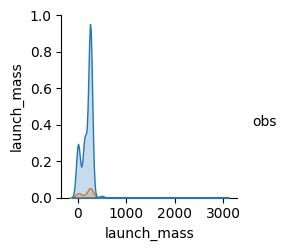

[1410/2000]: loss_d: 0.132, loss_g: -0.529
[1420/2000]: loss_d: 0.126, loss_g: -0.540
[1430/2000]: loss_d: 0.125, loss_g: -0.517
[1440/2000]: loss_d: 0.121, loss_g: -0.518
[1450/2000]: loss_d: 0.123, loss_g: -0.509


2013.0


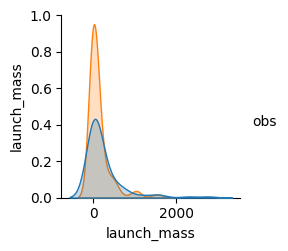

[1460/2000]: loss_d: 0.117, loss_g: -0.509
[1470/2000]: loss_d: 0.126, loss_g: -0.497
[1480/2000]: loss_d: 0.114, loss_g: -0.503
[1490/2000]: loss_d: 0.126, loss_g: -0.479
[1500/2000]: loss_d: 0.126, loss_g: -0.487


2016.0


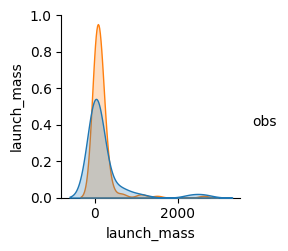

[1510/2000]: loss_d: 0.112, loss_g: -0.502
[1520/2000]: loss_d: 0.120, loss_g: -0.497
[1530/2000]: loss_d: 0.121, loss_g: -0.518
[1540/2000]: loss_d: 0.122, loss_g: -0.519
[1550/2000]: loss_d: 0.178, loss_g: -0.586


2021.0


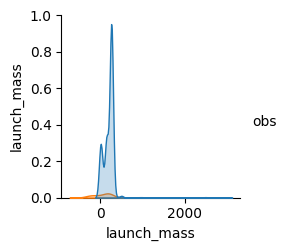

[1560/2000]: loss_d: 0.103, loss_g: -0.475
[1570/2000]: loss_d: 0.126, loss_g: -0.572
[1580/2000]: loss_d: 0.128, loss_g: -0.507
[1590/2000]: loss_d: 0.134, loss_g: -0.514
[1600/2000]: loss_d: 0.135, loss_g: -0.511


2019.0


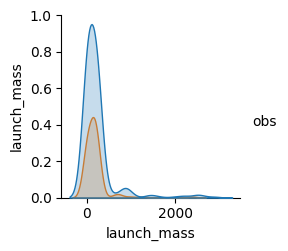

[1610/2000]: loss_d: 0.123, loss_g: -0.533
[1620/2000]: loss_d: 0.131, loss_g: -0.514
[1630/2000]: loss_d: 0.131, loss_g: -0.514
[1640/2000]: loss_d: 0.137, loss_g: -0.503
[1650/2000]: loss_d: 0.104, loss_g: -0.511


2021.0


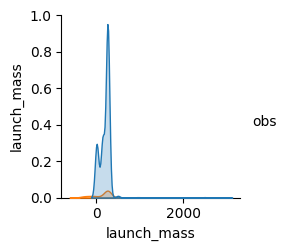

[1660/2000]: loss_d: 0.081, loss_g: -0.369
[1670/2000]: loss_d: 0.159, loss_g: -0.555
[1680/2000]: loss_d: 0.215, loss_g: -0.495
[1690/2000]: loss_d: 0.144, loss_g: -0.555
[1700/2000]: loss_d: 0.143, loss_g: -0.529


2020.0


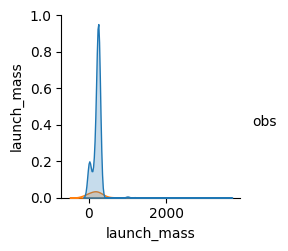

[1710/2000]: loss_d: 0.157, loss_g: -0.529
[1720/2000]: loss_d: 0.144, loss_g: -0.534
[1730/2000]: loss_d: 0.143, loss_g: -0.482
[1740/2000]: loss_d: 0.130, loss_g: -0.468
[1750/2000]: loss_d: 0.148, loss_g: -0.567


2020.0


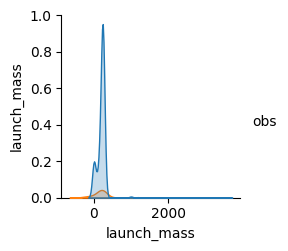

[1760/2000]: loss_d: 0.137, loss_g: -0.535
[1770/2000]: loss_d: 0.120, loss_g: -0.523
[1780/2000]: loss_d: 0.129, loss_g: -0.535
[1790/2000]: loss_d: 0.128, loss_g: -0.520
[1800/2000]: loss_d: 0.123, loss_g: -0.507


2021.0


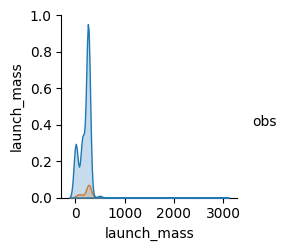

[1810/2000]: loss_d: 0.124, loss_g: -0.523
[1820/2000]: loss_d: 0.109, loss_g: -0.510
[1830/2000]: loss_d: 0.119, loss_g: -0.517
[1840/2000]: loss_d: 0.228, loss_g: -0.584
[1850/2000]: loss_d: 0.126, loss_g: -0.491


2019.0


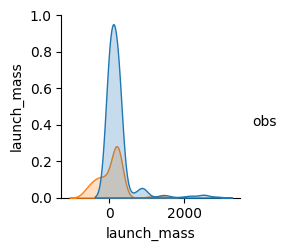

[1860/2000]: loss_d: 0.117, loss_g: -0.498
[1870/2000]: loss_d: 0.163, loss_g: -0.557
[1880/2000]: loss_d: 0.092, loss_g: -0.466
[1890/2000]: loss_d: 0.126, loss_g: -0.495
[1900/2000]: loss_d: 0.125, loss_g: -0.524


2021.0


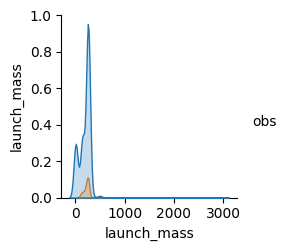

[1910/2000]: loss_d: 0.137, loss_g: -0.523
[1920/2000]: loss_d: 0.110, loss_g: -0.469
[1930/2000]: loss_d: 0.112, loss_g: -0.553
[1940/2000]: loss_d: 0.102, loss_g: -0.518
[1950/2000]: loss_d: 0.109, loss_g: -0.520


2019.0


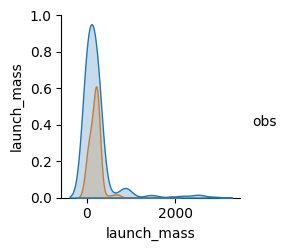

[1960/2000]: loss_d: 0.101, loss_g: -0.511
[1970/2000]: loss_d: 0.101, loss_g: -0.532
[1980/2000]: loss_d: 0.100, loss_g: -0.513
[1990/2000]: loss_d: 0.108, loss_g: -0.502


In [35]:
wgan_sats.train(n_epochs=N_EPOCHS)

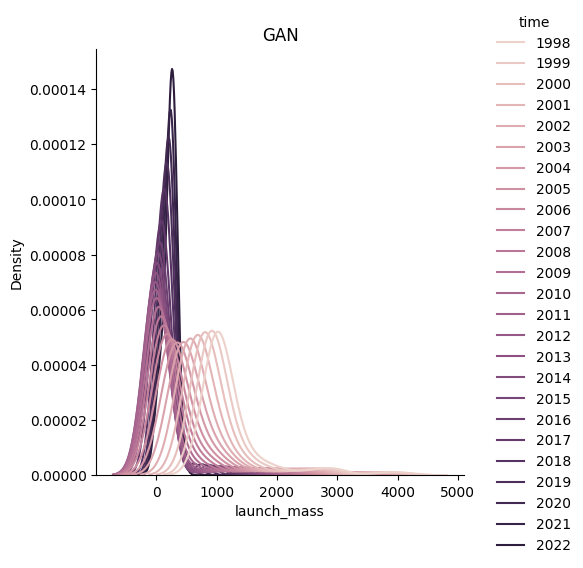

In [36]:

samples = wgan_sats.sample(time_periods=data.time.unique(), sample_size=100)

sns.displot(samples, x='launch_mass', hue='time', kind='kde')
plt.title('GAN')
plt.show()

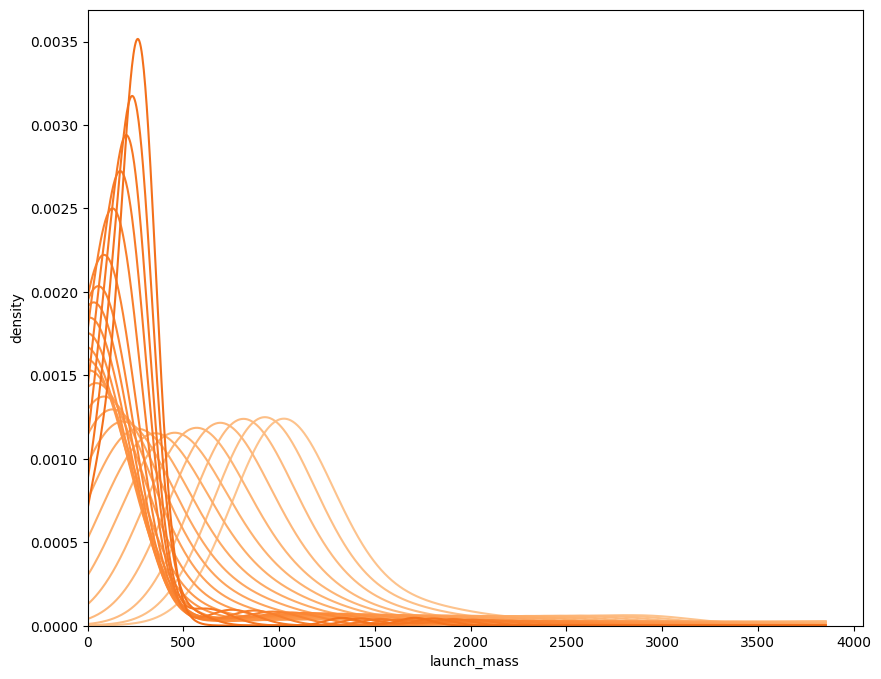

In [37]:
kde_wgan = get_kdes(samples, 'launch_mass', 'time', data.time.unique())
output_wgan = [kde_wgan[i].score_samples(grid_points.reshape(-1,1)) for i in data.time.unique()]

plt.figure(dpi=100, figsize=(10,8))

for n, o in zip( np.linspace(0.3 ,0.6 , data.time.nunique()), output_wgan):
  plt.plot(grid_points, np.exp(o), color=ORANGE(n))

plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=0)

plt.xlabel('launch_mass')
plt.ylabel('density');

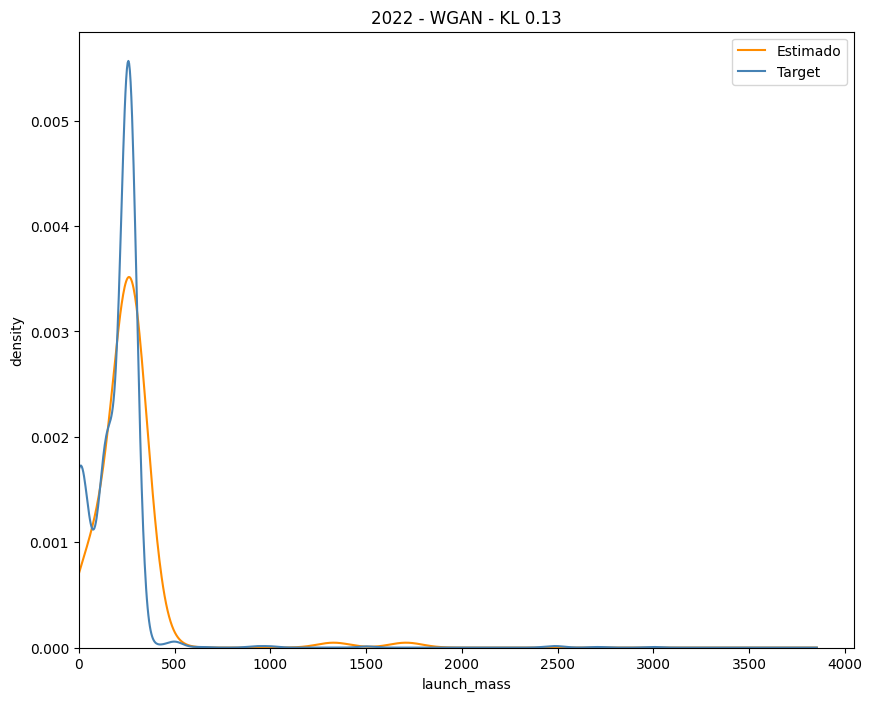

In [38]:
#kde_wgan = get_kdes(samples[samples.time==2022], 'launch_mass', 'time', [2022])
#output_wgan = kde_wgan[2022].score_samples(grid_points.reshape(-1,1))

KL_wgan = get_kl( np.exp(output_wgan[-1])[1:-1], np.exp(data_matrix[-1])[1:-1] )

plt.figure(dpi=100, figsize=(10,8))

plt.plot(grid_points, np.exp(output_wgan[-1]), 'darkorange', label='Estimado')
plt.plot(grid_points, np.exp(data_matrix[-1]), 'steelblue', label='Target')
plt.legend()
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=0)
plt.title('2022 - WGAN - KL {:.2f}'.format(KL_wgan))

plt.xlabel('launch_mass')
plt.ylabel('density')

plt.show()